# Final Results

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_addons as tfa

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, ConvLSTM1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

tf.random.set_seed(42)

## Methods for loading datasets and creating model architectures

### Data

In [2]:
def load_file(file):
    df = pd.read_csv(file, header=0)
    labels = df['pain']
    df = df.drop(columns=['pain'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df, labels

def load_dataset(input_filepath, modality):
    feature_names = []
    classes = []
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if feature_names == []:
                feature_names = x.columns.values.tolist()
            if labels[0] not in classes:
                classes.append(labels[0])
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test, feature_names, classes

def load_earlyfusion_dataset(input_filepath):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    body_x = body_x.to_numpy()
                    face_x = face_x.to_numpy()
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            body_x = body_x.to_numpy()
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    face_x = face_x.to_numpy()
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

def load_latefusion_dataset(input_filepath, modality):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'train' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'test' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

In [3]:
def jitter(x, sigma=0.03):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

In [4]:
def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

### Models

In [5]:
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, class_weight=class_weight, verbose=2)
    return history

def train_fusioned(model, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10)
    history = model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], class_weight=class_weight, verbose=2)
    return history

### Dirichlet Markov Ensemble with soft voting

The Dirichlet ensemble weights the ensemble members based on validation set performance. The weight optimization search is performed with randomized search based on the dirichlet distribution. 
    
Soft voting involves summing the predicted probability scores for each class label and predicting the class label with the largest probability.

In [6]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


In [7]:
class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return

def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

### KFold CV

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 50

## 1. Uni-modal approaches

Training the different model architectures on single modalities (skeleton vs action units). 

### 1.1 Body modality (skeleton) models

#### Apply Data Augmentation

In [9]:
full_body_X_train, full_body_X_test, full_body_y_train, full_body_y_test, body_feature_names, classes = load_dataset('processed', 'skeleton')
full_body_X = full_body_X_train.copy()
full_body_y = full_body_y_train.copy()

print(full_body_X_train.shape, full_body_y_train.shape)
print(full_body_X_test.shape, full_body_y_test.shape)

n_length, body_features, body_outputs = full_body_X_train.shape[2], full_body_X_train.shape[-1], full_body_y_test.shape[1]

(510, 1, 350, 38) (510, 4)
(105, 1, 350, 38) (105, 4)


In [10]:
jitter_X = jitter(full_body_X, sigma=0.03)

In [11]:
reshaped_X = full_body_X.reshape((full_body_X.shape[0], full_body_X.shape[2], full_body_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [12]:
augmented_X = np.concatenate((rotated_X[0:250], jitter_X[0:250]), axis=0)
add_y = np.concatenate((full_body_y[0:250], full_body_y[0:250]), axis=0)
full_X = np.concatenate((augmented_X, full_body_X), axis=0)
full_y = np.concatenate((add_y, full_body_y), axis=0)
full_X.shape

(1010, 1, 350, 38)

The train dataset is imbalanced

In [13]:
umild, lmoderate, lmild, umoderate = np.sum(full_y, axis=0)
total = umild + lmoderate + lmild + umoderate

print(classes[0], ':', umild, '({:.1f}% of total)'.format(umild / total * 100))
print(classes[2], ':', lmild, '({:.1f}% of total)'.format(lmild / total * 100))
print(classes[1], ':', lmoderate, '({:.1f}% of total)'.format(lmoderate / total * 100))
print(classes[3], ':', umoderate, '({:.1f}% of total)'.format(umoderate / total * 100))

UpperBody Mild : 489 (48.4% of total)
UpperBody Moderate : 324 (32.1% of total)
LowerBody Moderate : 124 (12.3% of total)
LowerBody Mild : 73 (7.2% of total)


In [14]:
weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for Upper Body Pain Mild Level: {:.2f}'.format(weight_for_0))
print('Weight for Upper Body Pain Moderate Level: {:.2f}'.format(weight_for_3))
print('Weight for Lower Body Pain Mild Level: {:.2f}'.format(weight_for_2))
print('Weight for Lower Body Pain Moderate Level: {:.2f}'.format(weight_for_1))

Weight for Upper Body Pain Mild Level: 1.03
Weight for Upper Body Pain Moderate Level: 6.92
Weight for Lower Body Pain Mild Level: 1.56
Weight for Lower Body Pain Moderate Level: 4.07


#### Train CNN + Bidirectional LSTM

In [15]:
acc = []
auc = []
precision = []
recall = []
f1 = []

In [16]:
def body_CNNLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=150, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=150, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
    conv1d_3 = TimeDistributed(Conv1D(filters=150, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=150, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(conv1d_3)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_4)
    conv1d_5 = TimeDistributed(Conv1D(filters=150, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(maxpool_2)
    conv1d_6 = TimeDistributed(Conv1D(filters=150, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(conv1d_5)
    maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_6)
    flatten = TimeDistributed(Flatten())(maxpool_3)
    lstm_1 = Bidirectional(LSTM(200, return_sequences=True))(flatten)
    lstm_2 = Bidirectional(LSTM(200, return_sequences=True))(lstm_1)
    lstm_3 = Bidirectional(LSTM(200))(lstm_2)
    dense_1 = Dense(256, activation='relu')(lstm_3)
    dense_2 = Dense(256, activation='relu')(dense_1)
    dense_3 = Dense(256, activation='relu')(dense_2)
    output = Dense(units=n_outputs, activation='softmax')(dense_3)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

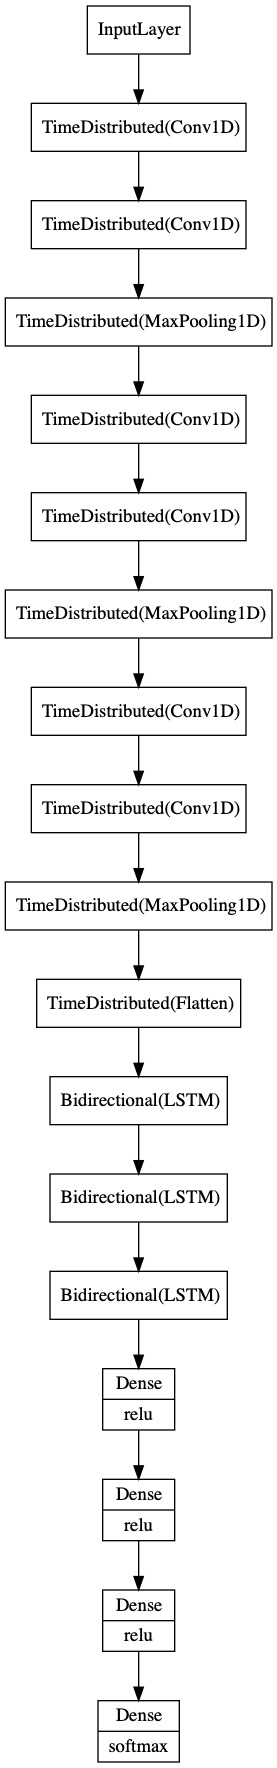

In [17]:
img_file = Path(os.path.abspath('')).parent / 'reports' / 'figures' / 'body_CNNLSTM.jpg'

body_cnnlstm = body_CNNLSTM(body_features, n_length, body_outputs)
tf.keras.utils.plot_model(body_cnnlstm, to_file=img_file, show_layer_names=False, show_layer_activations=True)

Epoch 1/100
7/7 - 22s - loss: 2.8014 - accuracy: 0.1844 - auc_1: 0.5005 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1616 - val_loss: 1.4009 - val_accuracy: 0.0990 - val_auc_1: 0.2427 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0450 - 22s/epoch - 3s/step
Epoch 2/100
7/7 - 8s - loss: 2.7980 - accuracy: 0.1349 - auc_1: 0.3184 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1174 - val_loss: 1.3950 - val_accuracy: 0.1139 - val_auc_1: 0.3397 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1213 - 8s/epoch - 1s/step
Epoch 3/100
7/7 - 6s - loss: 2.7910 - accuracy: 0.1745 - auc_1: 0.4249 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1484 - val_loss: 1.3949 - val_accuracy: 0.0990 - val_auc_1: 0.5110 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0450 - 6s/epoch - 844ms/step
Epoch 4/100
7/7 - 7s - loss: 2.7753 - accuracy: 0.2599 - auc_1: 0.5361 - precision_1: 0.0

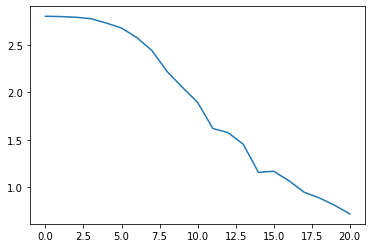

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
7/7 - 17s - loss: 2.7178 - accuracy: 0.3168 - auc_2: 0.5413 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1821 - val_loss: 1.3754 - val_accuracy: 0.4406 - val_auc_2: 0.6431 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1529 - 17s/epoch - 2s/step
Epoch 2/100
7/7 - 6s - loss: 2.7158 - accuracy: 0.3490 - auc_2: 0.6178 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1674 - val_loss: 1.3864 - val_accuracy: 0.2970 - val_auc_2: 0.4907 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.2207 - 6s/epoch - 821ms/step
Epoch 3/100
7/7 - 6s - loss: 2.7067 - accuracy: 0.3923 - auc_2: 0.6923 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.2710 - val_loss: 1.3818 - val_accuracy: 0.3119 - val_auc_2: 0.5518 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1823 - 6s/epoch - 820ms/step
Epoch 4/100
7/7 - 6s - loss: 2.6825 - accuracy: 0.4257 - auc_2: 0.6795 - precision_2: 

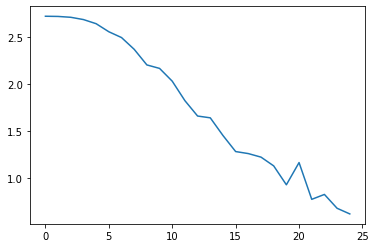

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
7/7 - 15s - loss: 2.7326 - accuracy: 0.1943 - auc_3: 0.4253 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1249 - val_loss: 1.3784 - val_accuracy: 0.4406 - val_auc_3: 0.6455 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1529 - 15s/epoch - 2s/step
Epoch 2/100
7/7 - 6s - loss: 2.7290 - accuracy: 0.4493 - auc_3: 0.6432 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1878 - val_loss: 1.3776 - val_accuracy: 0.4505 - val_auc_3: 0.6724 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1959 - 6s/epoch - 837ms/step
Epoch 3/100
7/7 - 6s - loss: 2.7204 - accuracy: 0.3800 - auc_3: 0.5692 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.2305 - val_loss: 1.3669 - val_accuracy: 0.4356 - val_auc_3: 0.6858 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.2059 - 6s/epoch - 830ms/step
Epoch 4/100
7/7 - 6s - loss: 2.7117 - accuracy: 0.4171 - auc_3: 0.6152 - precision_3: 

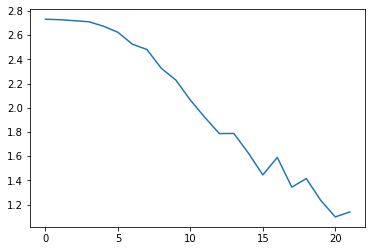

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
7/7 - 14s - loss: 2.8229 - accuracy: 0.1658 - auc_4: 0.4588 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.1455 - val_loss: 1.3915 - val_accuracy: 0.1139 - val_auc_4: 0.4150 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0511 - 14s/epoch - 2s/step
Epoch 2/100
7/7 - 6s - loss: 2.8220 - accuracy: 0.1572 - auc_4: 0.3575 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.1108 - val_loss: 1.3946 - val_accuracy: 0.1139 - val_auc_4: 0.3462 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0511 - 6s/epoch - 850ms/step
Epoch 3/100
7/7 - 6s - loss: 2.8193 - accuracy: 0.1411 - auc_4: 0.4477 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.0822 - val_loss: 1.3760 - val_accuracy: 0.5297 - val_auc_4: 0.7101 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.1806 - 6s/epoch - 842ms/step
Epoch 4/100
7/7 - 6s - loss: 2.8085 - accuracy: 0.2735 - auc_4: 0.5637 - precision_4: 

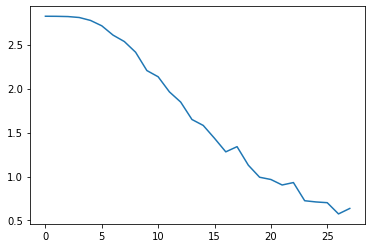

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
7/7 - 14s - loss: 2.8016 - accuracy: 0.1559 - auc_5: 0.4246 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1407 - val_loss: 1.3894 - val_accuracy: 0.3465 - val_auc_5: 0.4146 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1287 - 14s/epoch - 2s/step
Epoch 2/100
7/7 - 6s - loss: 2.8012 - accuracy: 0.2550 - auc_5: 0.4679 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1566 - val_loss: 1.3918 - val_accuracy: 0.0594 - val_auc_5: 0.3373 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0502 - 6s/epoch - 912ms/step
Epoch 3/100
7/7 - 6s - loss: 2.7925 - accuracy: 0.1498 - auc_5: 0.4233 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1290 - val_loss: 1.3821 - val_accuracy: 0.0842 - val_auc_5: 0.5148 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0734 - 6s/epoch - 918ms/step
Epoch 4/100
7/7 - 6s - loss: 2.7769 - accuracy: 0.1720 - auc_5: 0.5647 - precision_5: 

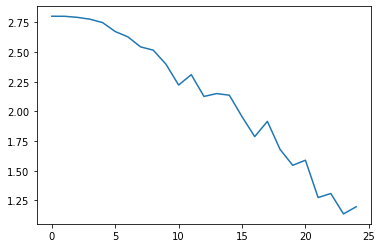

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


In [18]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    body_cnnlstm = body_CNNLSTM(body_features, n_length, body_outputs)
    history = train(body_cnnlstm, X_train, y_train, X_val, y_val, epochs=100, batch_size=128, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
    body_cnnlstm.save(model_path)

In [19]:
body_cnnlstm_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_results

{'Accuracy': 0.7727722883224487,
 'ROC/AUC': 0.9451225757598877,
 'Precision': 0.7979461789131165,
 'Recall': 0.7205445528030395,
 'F1-score': 0.7797717809677124}

In [20]:
_, acc, auc, precision, recall, f1 = body_cnnlstm.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('CNN + Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 40.95% - ROC/AUC: 0.72 - Precision: 0.34 - Recall: 0.23, F1 score: 0.30


#### Train RCNN

In [21]:
acc = []
auc = []
precision = []
recall = []
f1 = []

In [22]:
def body_RCNN(n_features, n_length, n_outputs):
   input = Input(shape=(1, n_length, n_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(input)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
   conv1d_2 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(maxpool_1)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
   conv1d_3 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(maxpool_2)
   bn_3 = TimeDistributed(BatchNormalization())(conv1d_3)
   maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_3)
   flatten = Flatten()(maxpool_3)
   dense_1 = Dense(256, activation='relu')(flatten)
   dense_2 = Dense(256, activation='relu')(dense_1)
   dense_3 = Dense(256, activation='relu')(dense_2)
   output = Dense(units=n_outputs, activation='softmax')(dense_3)
   model = Model(inputs=input, outputs=output)
   model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

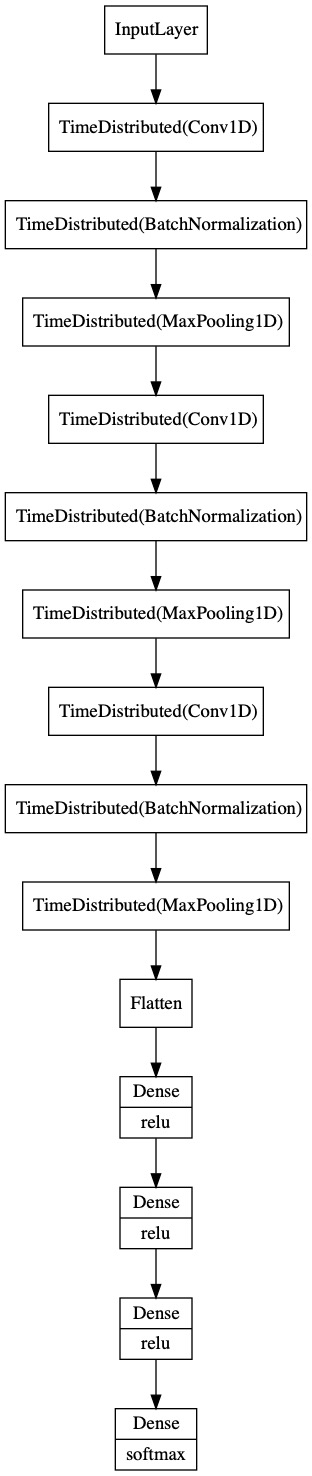

In [23]:
img_file = Path(os.path.abspath('')).parent / 'reports' / 'figures' / 'body_RCNN.jpg'

body_rcnn = body_RCNN(body_features, n_length, body_outputs)
tf.keras.utils.plot_model(body_rcnn, to_file=img_file, show_layer_names=False, show_layer_activations=True)

Epoch 1/100
13/13 - 12s - loss: 5.0108 - accuracy: 0.2500 - auc_7: 0.5291 - precision_7: 0.2857 - recall_7: 0.0990 - f1_score: 0.2062 - val_loss: 3.8231 - val_accuracy: 0.2525 - val_auc_7: 0.3558 - val_precision_7: 0.2567 - val_recall_7: 0.2376 - val_f1_score: 0.1478 - 12s/epoch - 914ms/step
Epoch 2/100
13/13 - 9s - loss: 2.8421 - accuracy: 0.3218 - auc_7: 0.5916 - precision_7: 0.3144 - recall_7: 0.0755 - f1_score: 0.3038 - val_loss: 1.8786 - val_accuracy: 0.2871 - val_auc_7: 0.5469 - val_precision_7: 0.2865 - val_recall_7: 0.2723 - val_f1_score: 0.1313 - 9s/epoch - 695ms/step
Epoch 3/100
13/13 - 11s - loss: 2.3384 - accuracy: 0.4183 - auc_7: 0.7035 - precision_7: 0.5651 - recall_7: 0.1881 - f1_score: 0.3961 - val_loss: 2.2844 - val_accuracy: 0.2822 - val_auc_7: 0.5260 - val_precision_7: 0.2814 - val_recall_7: 0.2772 - val_f1_score: 0.1595 - 11s/epoch - 827ms/step
Epoch 4/100
13/13 - 12s - loss: 2.1829 - accuracy: 0.5136 - auc_7: 0.7714 - precision_7: 0.6276 - recall_7: 0.2983 - f1_sco

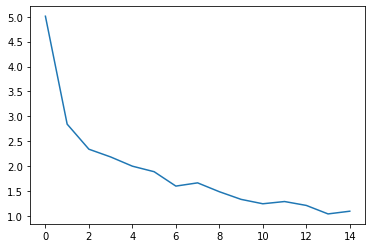

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


Epoch 1/100
13/13 - 12s - loss: 5.3607 - accuracy: 0.2673 - auc_8: 0.5401 - precision_8: 0.2466 - recall_8: 0.1139 - f1_score: 0.2343 - val_loss: 1.6517 - val_accuracy: 0.3267 - val_auc_8: 0.6205 - val_precision_8: 0.3679 - val_recall_8: 0.1931 - val_f1_score: 0.1959 - 12s/epoch - 953ms/step
Epoch 2/100
13/13 - 10s - loss: 2.8654 - accuracy: 0.3713 - auc_8: 0.6635 - precision_8: 0.3828 - recall_8: 0.1374 - f1_score: 0.3445 - val_loss: 1.8369 - val_accuracy: 0.4257 - val_auc_8: 0.6633 - val_precision_8: 0.4293 - val_recall_8: 0.4208 - val_f1_score: 0.1493 - 10s/epoch - 773ms/step
Epoch 3/100
13/13 - 10s - loss: 2.5452 - accuracy: 0.4332 - auc_8: 0.7037 - precision_8: 0.4526 - recall_8: 0.2129 - f1_score: 0.4069 - val_loss: 2.5014 - val_accuracy: 0.1485 - val_auc_8: 0.5055 - val_precision_8: 0.1508 - val_recall_8: 0.1485 - val_f1_score: 0.0652 - 10s/epoch - 737ms/step
Epoch 4/100
13/13 - 11s - loss: 2.1473 - accuracy: 0.4975 - auc_8: 0.7686 - precision_8: 0.5705 - recall_8: 0.3106 - f1_s

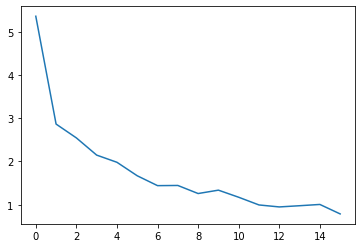

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


Epoch 1/100
13/13 - 12s - loss: 5.1898 - accuracy: 0.2624 - auc_9: 0.5266 - precision_9: 0.2609 - recall_9: 0.1114 - f1_score: 0.2311 - val_loss: 1.5000 - val_accuracy: 0.2277 - val_auc_9: 0.5771 - val_precision_9: 0.2647 - val_recall_9: 0.0446 - val_f1_score: 0.1629 - 12s/epoch - 895ms/step
Epoch 2/100
13/13 - 9s - loss: 2.8025 - accuracy: 0.3626 - auc_9: 0.6418 - precision_9: 0.3480 - recall_9: 0.0879 - f1_score: 0.3149 - val_loss: 1.4857 - val_accuracy: 0.3515 - val_auc_9: 0.6278 - val_precision_9: 0.3659 - val_recall_9: 0.2228 - val_f1_score: 0.1599 - 9s/epoch - 720ms/step
Epoch 3/100
13/13 - 9s - loss: 2.3683 - accuracy: 0.4084 - auc_9: 0.7140 - precision_9: 0.5045 - recall_9: 0.2067 - f1_score: 0.3846 - val_loss: 1.3899 - val_accuracy: 0.3614 - val_auc_9: 0.6700 - val_precision_9: 0.3370 - val_recall_9: 0.1535 - val_f1_score: 0.1972 - 9s/epoch - 724ms/step
Epoch 4/100
13/13 - 9s - loss: 2.1414 - accuracy: 0.4913 - auc_9: 0.7617 - precision_9: 0.5544 - recall_9: 0.2710 - f1_score:

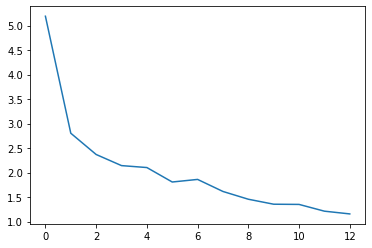

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


Epoch 1/100
13/13 - 12s - loss: 4.7058 - accuracy: 0.2537 - auc_10: 0.5053 - precision_10: 0.2387 - recall_10: 0.0916 - f1_score: 0.2253 - val_loss: 3.4915 - val_accuracy: 0.2624 - val_auc_10: 0.3721 - val_precision_10: 0.2842 - val_recall_10: 0.2574 - val_f1_score: 0.1439 - 12s/epoch - 917ms/step
Epoch 2/100
13/13 - 10s - loss: 2.8201 - accuracy: 0.3342 - auc_10: 0.6117 - precision_10: 0.3439 - recall_10: 0.0941 - f1_score: 0.3174 - val_loss: 1.5558 - val_accuracy: 0.2723 - val_auc_10: 0.6169 - val_precision_10: 0.1667 - val_recall_10: 0.0297 - val_f1_score: 0.1395 - 10s/epoch - 772ms/step
Epoch 3/100
13/13 - 10s - loss: 2.5988 - accuracy: 0.3824 - auc_10: 0.6694 - precision_10: 0.4427 - recall_10: 0.1770 - f1_score: 0.3624 - val_loss: 1.4764 - val_accuracy: 0.5198 - val_auc_10: 0.6453 - val_precision_10: 0.5140 - val_recall_10: 0.4554 - val_f1_score: 0.1716 - 10s/epoch - 746ms/step
Epoch 4/100
13/13 - 10s - loss: 2.2983 - accuracy: 0.4530 - auc_10: 0.7383 - precision_10: 0.5093 - rec

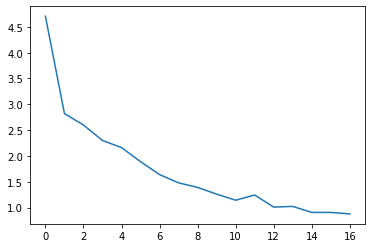

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


Epoch 1/100
13/13 - 12s - loss: 4.6933 - accuracy: 0.2958 - auc_11: 0.5502 - precision_11: 0.3089 - recall_11: 0.1250 - f1_score: 0.2623 - val_loss: 3.3865 - val_accuracy: 0.3465 - val_auc_11: 0.4818 - val_precision_11: 0.3452 - val_recall_11: 0.3366 - val_f1_score: 0.1296 - 12s/epoch - 924ms/step
Epoch 2/100
13/13 - 9s - loss: 3.2341 - accuracy: 0.2822 - auc_11: 0.5521 - precision_11: 0.3307 - recall_11: 0.1052 - f1_score: 0.2667 - val_loss: 1.3582 - val_accuracy: 0.4010 - val_auc_11: 0.6959 - val_precision_11: 0.3942 - val_recall_11: 0.2030 - val_f1_score: 0.2134 - 9s/epoch - 716ms/step
Epoch 3/100
13/13 - 9s - loss: 2.5722 - accuracy: 0.4196 - auc_11: 0.6852 - precision_11: 0.4127 - recall_11: 0.1609 - f1_score: 0.3912 - val_loss: 1.4950 - val_accuracy: 0.4455 - val_auc_11: 0.6448 - val_precision_11: 0.3818 - val_recall_11: 0.1040 - val_f1_score: 0.1922 - 9s/epoch - 715ms/step
Epoch 4/100
13/13 - 9s - loss: 2.1998 - accuracy: 0.4752 - auc_11: 0.7502 - precision_11: 0.5671 - recall_1

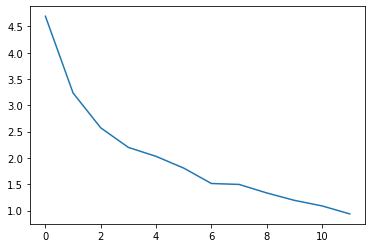

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/assets/assets


In [24]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    body_rcnn = body_RCNN(body_features, n_length, body_outputs)
    history = train(body_rcnn, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
    body_rcnn.save(model_path)

In [25]:
body_rcnn_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_results

{'Accuracy': 0.7806930780410767,
 'ROC/AUC': 0.9468693137168884,
 'Precision': 0.8060536623001099,
 'Recall': 0.7405940651893616,
 'F1-score': 0.7649234414100647}

In [26]:
_, acc, auc, precision, recall, f1 = body_rcnn.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 23.81% - ROC/AUC: 0.51 - Precision: 0.24 - Recall: 0.12, F1 score: 0.19


### 1.2 Face modality (Action units)

#### Apply Data Augmentation

In [73]:
face_X_train, face_X_test, face_y_train, face_y_test, face_feature_names, c = load_dataset('processed', 'AUs')
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

n_length, face_features, face_outputs = face_X_train.shape[2], face_X_train.shape[-1], face_y_train.shape[1]

(495, 1, 350, 10) (495, 4)
(102, 1, 350, 10) (102, 4)


In [74]:
jitter_X = jitter(face_X, sigma=0.03)

In [75]:
reshaped_X = face_X.reshape((face_X.shape[0], face_X.shape[2], face_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [30]:
augmented_X = np.concatenate((rotated_X[0:250], jitter_X[0:250]), axis=0)
add_y = np.concatenate((face_y[0:250], face_y[0:250]), axis=0)
full_X = np.concatenate((augmented_X, face_X), axis=0)
full_y = np.concatenate((add_y, face_y), axis=0)
full_X.shape

(995, 1, 350, 10)

In [76]:
umild, lmoderate, lmild, umoderate = np.sum(full_y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for Upper Body Pain Mild Level: {:.2f}'.format(weight_for_0))
print('Weight for Upper Body Pain Moderate Level: {:.2f}'.format(weight_for_3))
print('Weight for Lower Body Pain Mild Level: {:.2f}'.format(weight_for_2))
print('Weight for Lower Body Pain Moderate Level: {:.2f}'.format(weight_for_1))

Weight for Upper Body Pain Mild Level: 1.04
Weight for Upper Body Pain Moderate Level: 6.91
Weight for Lower Body Pain Mild Level: 1.54
Weight for Lower Body Pain Moderate Level: 4.04


#### Train CNN + Bidirectional LSTM

In [64]:
acc = []
auc = []
precision = []
recall = []
f1 = []

In [65]:
def face_CNNLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
    conv1d_3 = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(conv1d_3)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_4)
    conv1d_5 = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(maxpool_2)
    conv1d_6 = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(conv1d_5)
    maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_6)
    flatten = TimeDistributed(Flatten())(maxpool_3)
    lstm_1 = Bidirectional(LSTM(250, return_sequences=True))(flatten)
    lstm_2 = Bidirectional(LSTM(250, return_sequences=True))(lstm_1)
    lstm_3 = Bidirectional(LSTM(250))(lstm_2)
    dense_1 = Dense(250, activation='tanh')(lstm_3)
    dense_2 = Dense(250, activation='tanh')(dense_1)
    dense_3 = Dense(250, activation='tanh')(dense_2)
    output = Dense(units=n_outputs, activation='softmax')(dense_3)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

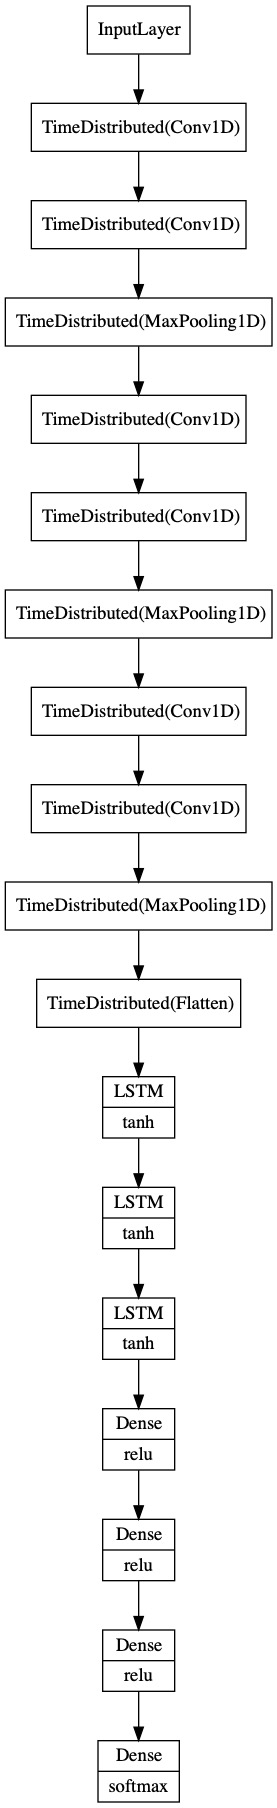

In [34]:
img_file = Path(os.path.abspath('')).parent / 'reports' / 'figures' / 'face_CNNLSTM.jpg'

face_cnnlstm = face_CNNLSTM(face_features, n_length, face_outputs)
tf.keras.utils.plot_model(face_cnnlstm, to_file=img_file, show_layer_names=False, show_layer_activations=True)

Epoch 1/100
7/7 - 14s - loss: 2.7813 - accuracy: 0.3291 - auc_44: 0.6205 - precision_44: 0.0000e+00 - recall_44: 0.0000e+00 - f1_score: 0.2320 - val_loss: 1.3764 - val_accuracy: 0.2764 - val_auc_44: 0.6090 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.1483 - 14s/epoch - 2s/step
Epoch 2/100
7/7 - 5s - loss: 2.7302 - accuracy: 0.3857 - auc_44: 0.6542 - precision_44: 0.0000e+00 - recall_44: 0.0000e+00 - f1_score: 0.2849 - val_loss: 1.4481 - val_accuracy: 0.2663 - val_auc_44: 0.4573 - val_precision_44: 1.0000 - val_recall_44: 0.0050 - val_f1_score: 0.2005 - 5s/epoch - 655ms/step
Epoch 3/100
7/7 - 5s - loss: 2.6957 - accuracy: 0.3580 - auc_44: 0.5890 - precision_44: 0.7333 - recall_44: 0.0138 - f1_score: 0.2967 - val_loss: 1.3967 - val_accuracy: 0.2613 - val_auc_44: 0.5189 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.1669 - 5s/epoch - 649ms/step
Epoch 4/100
7/7 - 5s - loss: 2.6443 - accuracy: 0.3153 - auc_44: 0.6114 - precision_

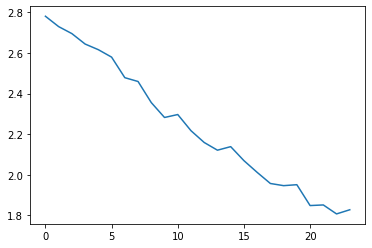

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
7/7 - 15s - loss: 2.7377 - accuracy: 0.1972 - auc_45: 0.4957 - precision_45: 0.0000e+00 - recall_45: 0.0000e+00 - f1_score: 0.2004 - val_loss: 1.3364 - val_accuracy: 0.3920 - val_auc_45: 0.6927 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.2249 - 15s/epoch - 2s/step
Epoch 2/100
7/7 - 4s - loss: 2.7098 - accuracy: 0.3141 - auc_45: 0.6094 - precision_45: 0.0000e+00 - recall_45: 0.0000e+00 - f1_score: 0.2483 - val_loss: 1.3010 - val_accuracy: 0.4372 - val_auc_45: 0.6769 - val_precision_45: 0.6875 - val_recall_45: 0.0553 - val_f1_score: 0.1999 - 4s/epoch - 638ms/step
Epoch 3/100
7/7 - 4s - loss: 2.6625 - accuracy: 0.3053 - auc_45: 0.6198 - precision_45: 0.7059 - recall_45: 0.0151 - f1_score: 0.2297 - val_loss: 1.3191 - val_accuracy: 0.2362 - val_auc_45: 0.5644 - val_precision_45: 0.6667 - val_recall_45: 0.0201 - val_f1_score: 0.2175 - 4s/epoch - 641ms/step
Epoch 4/100
7/7 - 4s - loss: 2.5838 - accuracy: 0.2739 - auc_45: 0.5959 - precision_45: 0.68

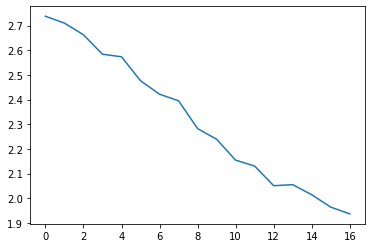

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
7/7 - 15s - loss: 2.7087 - accuracy: 0.2852 - auc_46: 0.5792 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - f1_score: 0.2349 - val_loss: 1.3681 - val_accuracy: 0.4523 - val_auc_46: 0.6768 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.1696 - 15s/epoch - 2s/step
Epoch 2/100
7/7 - 5s - loss: 2.6876 - accuracy: 0.3769 - auc_46: 0.6725 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - f1_score: 0.2546 - val_loss: 1.3620 - val_accuracy: 0.2563 - val_auc_46: 0.6281 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.1654 - 5s/epoch - 647ms/step
Epoch 3/100
7/7 - 5s - loss: 2.6508 - accuracy: 0.3040 - auc_46: 0.6401 - precision_46: 0.4286 - recall_46: 0.0038 - f1_score: 0.2035 - val_loss: 1.3538 - val_accuracy: 0.3719 - val_auc_46: 0.6422 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.2869 - 5s/epoch - 651ms/step
Epoch 4/100
7/7 - 4s - loss: 2.5981 - accuracy: 0.4397 - auc_46: 0.6968 - pr

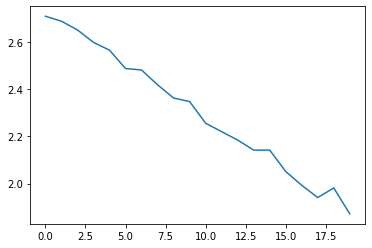

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
7/7 - 14s - loss: 2.8567 - accuracy: 0.1683 - auc_47: 0.4158 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - f1_score: 0.1582 - val_loss: 1.3673 - val_accuracy: 0.3568 - val_auc_47: 0.6304 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.2355 - 14s/epoch - 2s/step
Epoch 2/100
7/7 - 5s - loss: 2.8441 - accuracy: 0.2927 - auc_47: 0.5463 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - f1_score: 0.2613 - val_loss: 1.3768 - val_accuracy: 0.1206 - val_auc_47: 0.5092 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.1235 - 5s/epoch - 645ms/step
Epoch 3/100
7/7 - 4s - loss: 2.8077 - accuracy: 0.2048 - auc_47: 0.4976 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - f1_score: 0.1981 - val_loss: 1.3716 - val_accuracy: 0.1859 - val_auc_47: 0.4943 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.1543 - 4s/epoch - 638ms/step
Epoch 4/100
7/7 - 5s - loss: 2.7235 - accuracy: 0.2450 - auc_47: 0.5

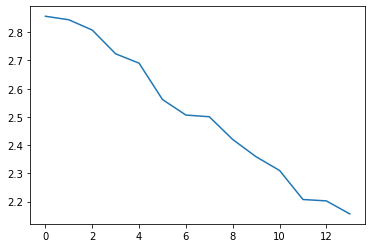

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
7/7 - 15s - loss: 2.7933 - accuracy: 0.1960 - auc_48: 0.5078 - precision_48: 0.0000e+00 - recall_48: 0.0000e+00 - f1_score: 0.1755 - val_loss: 1.3908 - val_accuracy: 0.1307 - val_auc_48: 0.3766 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_f1_score: 0.1203 - 15s/epoch - 2s/step
Epoch 2/100
7/7 - 4s - loss: 2.7740 - accuracy: 0.1859 - auc_48: 0.4668 - precision_48: 0.0000e+00 - recall_48: 0.0000e+00 - f1_score: 0.1894 - val_loss: 1.3984 - val_accuracy: 0.1307 - val_auc_48: 0.4494 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_f1_score: 0.1160 - 4s/epoch - 635ms/step
Epoch 3/100
7/7 - 4s - loss: 2.7016 - accuracy: 0.2437 - auc_48: 0.5417 - precision_48: 0.5000 - recall_48: 0.0038 - f1_score: 0.2086 - val_loss: 1.3699 - val_accuracy: 0.2161 - val_auc_48: 0.5409 - val_precision_48: 0.3333 - val_recall_48: 0.0050 - val_f1_score: 0.1801 - 4s/epoch - 634ms/step
Epoch 4/100
7/7 - 4s - loss: 2.6295 - accuracy: 0.2751 - auc_48: 0.6004 - precision_

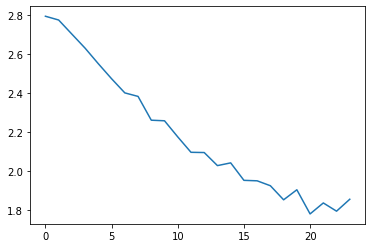

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


In [66]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    face_cnnlstm = face_CNNLSTM(face_features, n_length, face_outputs)
    history = train(face_cnnlstm, X_train, y_train, X_val, y_val, epochs=100, batch_size=128, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
    face_cnnlstm.save(model_path)

In [67]:
face_cnnlstm_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_results

{'Accuracy': 0.4821608066558838,
 'ROC/AUC': 0.7901160717010498,
 'Precision': 0.7488232374191284,
 'Recall': 0.31658291816711426,
 'F1-score': 0.4684634029865265}

In [68]:
_, acc, auc, precision, recall, f1 = face_cnnlstm.evaluate(face_X_test, face_y_test, verbose=0)
print('CNN + Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN + Bidirectional LSTM:
Accuracy: 28.43% - ROC/AUC: 0.63 - Precision: 0.40 - Recall: 0.20, F1 score: 0.19


#### Train RCNN

In [69]:
acc = []
auc = []
precision = []
recall = []
f1 = []

In [70]:
def face_RCNN(n_features, n_length, n_outputs):
   input = Input(shape=(1, n_length, n_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='he_normal'))(input)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
   conv1d_2 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='he_normal'))(maxpool_1)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
   conv1d_3 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='he_normal'))(maxpool_2)
   bn_3 = TimeDistributed(BatchNormalization())(conv1d_3)
   maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_3)
   flatten = Flatten()(maxpool_3)
   dense_1 = Dense(256, activation='tanh')(flatten)
   dense_2 = Dense(256, activation='tanh')(dense_1)
   dense_3 = Dense(256, activation='tanh')(dense_2)
   output = Dense(units=n_outputs, activation='softmax')(dense_3)
   model = Model(inputs=input, outputs=output)
   model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

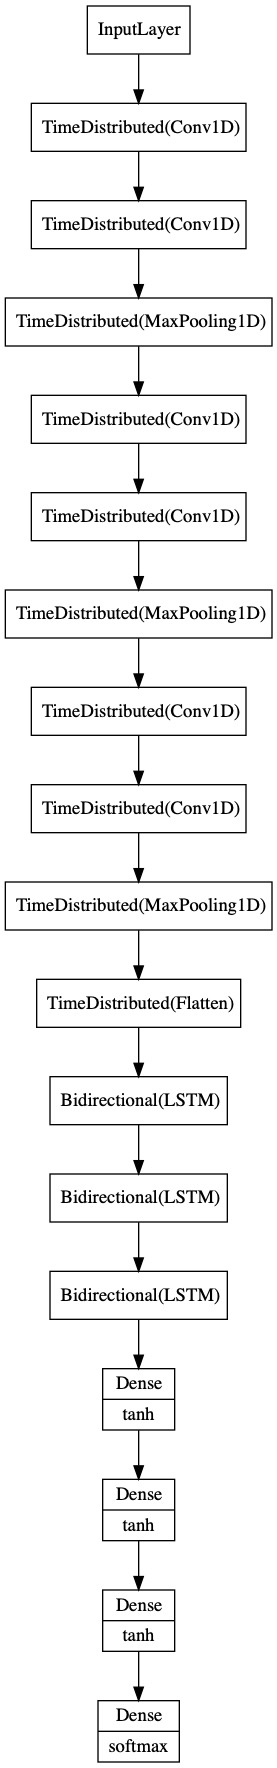

In [71]:
img_file = Path(os.path.abspath('')).parent / 'reports' / 'figures' / 'face_RCNN.jpg'

face_rcnn = face_RCNN(face_features, n_length, face_outputs)
tf.keras.utils.plot_model(face_rcnn, to_file=img_file, show_layer_names=False, show_layer_activations=True)

Epoch 1/100
4/4 - 12s - loss: 5.0612 - accuracy: 0.3078 - auc_51: 0.5247 - precision_51: 0.2840 - recall_51: 0.1809 - f1_score: 0.2551 - val_loss: 1.2694 - val_accuracy: 0.4322 - val_auc_51: 0.6804 - val_precision_51: 0.5077 - val_recall_51: 0.1658 - val_f1_score: 0.2324 - 12s/epoch - 3s/step
Epoch 2/100
4/4 - 9s - loss: 2.6974 - accuracy: 0.3631 - auc_51: 0.6362 - precision_51: 0.6598 - recall_51: 0.0804 - f1_score: 0.2872 - val_loss: 1.2908 - val_accuracy: 0.3719 - val_auc_51: 0.6363 - val_precision_51: 0.5952 - val_recall_51: 0.1256 - val_f1_score: 0.2384 - 9s/epoch - 2s/step
Epoch 3/100
4/4 - 11s - loss: 2.4811 - accuracy: 0.3882 - auc_51: 0.7020 - precision_51: 0.6250 - recall_51: 0.0879 - f1_score: 0.3564 - val_loss: 1.3890 - val_accuracy: 0.1910 - val_auc_51: 0.5768 - val_precision_51: 0.3182 - val_recall_51: 0.1055 - val_f1_score: 0.1739 - 11s/epoch - 3s/step
Epoch 4/100
4/4 - 10s - loss: 2.3466 - accuracy: 0.3957 - auc_51: 0.7188 - precision_51: 0.6358 - recall_51: 0.1294 - f1

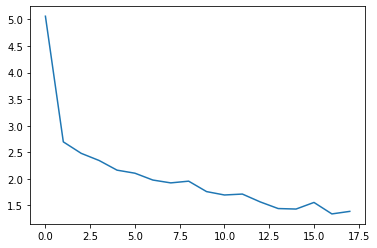

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
4/4 - 12s - loss: 5.3522 - accuracy: 0.2563 - auc_52: 0.5085 - precision_52: 0.2753 - recall_52: 0.1847 - f1_score: 0.2147 - val_loss: 1.3536 - val_accuracy: 0.4472 - val_auc_52: 0.6337 - val_precision_52: 0.4000 - val_recall_52: 0.0302 - val_f1_score: 0.2011 - 12s/epoch - 3s/step
Epoch 2/100
4/4 - 9s - loss: 3.3320 - accuracy: 0.3794 - auc_52: 0.6546 - precision_52: 0.5000 - recall_52: 0.1118 - f1_score: 0.2604 - val_loss: 1.4125 - val_accuracy: 0.2613 - val_auc_52: 0.5851 - val_precision_52: 0.2727 - val_recall_52: 0.0151 - val_f1_score: 0.1521 - 9s/epoch - 2s/step
Epoch 3/100
4/4 - 9s - loss: 2.6052 - accuracy: 0.4686 - auc_52: 0.6982 - precision_52: 0.5977 - recall_52: 0.0653 - f1_score: 0.3734 - val_loss: 1.4012 - val_accuracy: 0.2563 - val_auc_52: 0.5877 - val_precision_52: 0.3750 - val_recall_52: 0.0302 - val_f1_score: 0.1940 - 9s/epoch - 2s/step
Epoch 4/100
4/4 - 9s - loss: 2.2845 - accuracy: 0.4334 - auc_52: 0.7251 - precision_52: 0.7902 - recall_52: 0.1420 - f1_sc

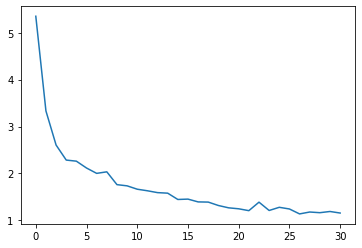

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
4/4 - 11s - loss: 4.8157 - accuracy: 0.2513 - auc_53: 0.5857 - precision_53: 0.2356 - recall_53: 0.0980 - f1_score: 0.2251 - val_loss: 1.3206 - val_accuracy: 0.3216 - val_auc_53: 0.6512 - val_precision_53: 1.0000 - val_recall_53: 0.0101 - val_f1_score: 0.2318 - 11s/epoch - 3s/step
Epoch 2/100
4/4 - 10s - loss: 3.0767 - accuracy: 0.3417 - auc_53: 0.6413 - precision_53: 0.4634 - recall_53: 0.1193 - f1_score: 0.2685 - val_loss: 1.4461 - val_accuracy: 0.1558 - val_auc_53: 0.5266 - val_precision_53: 0.1579 - val_recall_53: 0.0151 - val_f1_score: 0.1495 - 10s/epoch - 2s/step
Epoch 3/100
4/4 - 9s - loss: 2.4357 - accuracy: 0.4133 - auc_53: 0.6970 - precision_53: 0.4545 - recall_53: 0.1508 - f1_score: 0.3657 - val_loss: 1.2959 - val_accuracy: 0.3065 - val_auc_53: 0.6627 - val_precision_53: 0.5303 - val_recall_53: 0.1759 - val_f1_score: 0.1743 - 9s/epoch - 2s/step
Epoch 4/100
4/4 - 9s - loss: 2.2522 - accuracy: 0.5101 - auc_53: 0.7846 - precision_53: 0.7609 - recall_53: 0.2198 - f1_

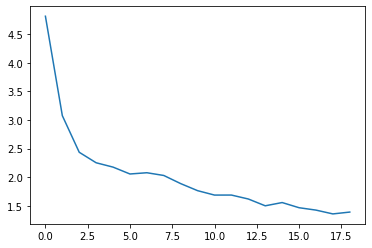

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
4/4 - 12s - loss: 6.2364 - accuracy: 0.2035 - auc_54: 0.4747 - precision_54: 0.1761 - recall_54: 0.1131 - f1_score: 0.1927 - val_loss: 1.2553 - val_accuracy: 0.2864 - val_auc_54: 0.6846 - val_precision_54: 0.3750 - val_recall_54: 0.0452 - val_f1_score: 0.2099 - 12s/epoch - 3s/step
Epoch 2/100
4/4 - 9s - loss: 2.6928 - accuracy: 0.3693 - auc_54: 0.6983 - precision_54: 0.5802 - recall_54: 0.0955 - f1_score: 0.3304 - val_loss: 1.4832 - val_accuracy: 0.1709 - val_auc_54: 0.4944 - val_precision_54: 0.2121 - val_recall_54: 0.0352 - val_f1_score: 0.1572 - 9s/epoch - 2s/step
Epoch 3/100
4/4 - 9s - loss: 2.4621 - accuracy: 0.4146 - auc_54: 0.6816 - precision_54: 0.5208 - recall_54: 0.0942 - f1_score: 0.3880 - val_loss: 1.3087 - val_accuracy: 0.3015 - val_auc_54: 0.6449 - val_precision_54: 0.3913 - val_recall_54: 0.0452 - val_f1_score: 0.2581 - 9s/epoch - 2s/step
Epoch 4/100
4/4 - 9s - loss: 2.2901 - accuracy: 0.4812 - auc_54: 0.7630 - precision_54: 0.7759 - recall_54: 0.1696 - f1_sc

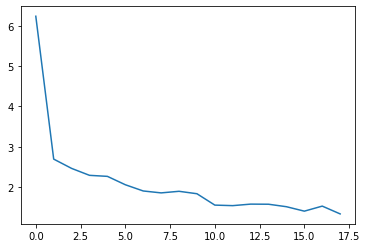

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/100
4/4 - 11s - loss: 5.3252 - accuracy: 0.2098 - auc_55: 0.4659 - precision_55: 0.2197 - recall_55: 0.1432 - f1_score: 0.1964 - val_loss: 1.5637 - val_accuracy: 0.1910 - val_auc_55: 0.3978 - val_precision_55: 0.4545 - val_recall_55: 0.0503 - val_f1_score: 0.1885 - 11s/epoch - 3s/step
Epoch 2/100
4/4 - 9s - loss: 2.7363 - accuracy: 0.2990 - auc_55: 0.5619 - precision_55: 0.3208 - recall_55: 0.0854 - f1_score: 0.2984 - val_loss: 1.5669 - val_accuracy: 0.1106 - val_auc_55: 0.3919 - val_precision_55: 0.1562 - val_recall_55: 0.0251 - val_f1_score: 0.1121 - 9s/epoch - 2s/step
Epoch 3/100
4/4 - 9s - loss: 2.4743 - accuracy: 0.3681 - auc_55: 0.6551 - precision_55: 0.5549 - recall_55: 0.1269 - f1_score: 0.3397 - val_loss: 1.3746 - val_accuracy: 0.2563 - val_auc_55: 0.5556 - val_precision_55: 0.5000 - val_recall_55: 0.0754 - val_f1_score: 0.1829 - 9s/epoch - 2s/step
Epoch 4/100
4/4 - 9s - loss: 2.2020 - accuracy: 0.4837 - auc_55: 0.7636 - precision_55: 0.7590 - recall_55: 0.1859 - f1_sc

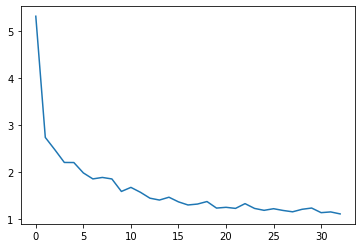

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


In [77]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    face_rcnn = face_RCNN(face_features, n_length, face_outputs)
    history = train(face_rcnn, X_train, y_train, X_val, y_val, epochs=100, batch_size=256, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
    face_rcnn.save(model_path)

In [78]:
face_rcnn_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_results

{'Accuracy': 0.689195990562439,
 'ROC/AUC': 0.9188706398010253,
 'Precision': 0.899638032913208,
 'Recall': 0.5957286477088928,
 'F1-score': 0.6622355937957763}

In [79]:
_, acc, auc, precision, recall, f1 = face_rcnn.evaluate(face_X_test, face_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 39.22% - ROC/AUC: 0.67 - Precision: 0.43 - Recall: 0.32, F1 score: 0.16


## 2. Early Fusion - Fusion is performed at feature level

Early fusion concatenates features at the input level, then all the work is on the classifier. 

My initial assumption is that perhaps early fusion is not the best idea because the face modality is missing about half the times (OpenFace could not capture facial action units from the videos), which makes the dataset smaller. 
I did not replace the missing facial values because I thought null values will bring no benefit (I assume?) and adding for example zero would mean the absence of action units which I'm afraid might actually "trick" the model in the case where a person has pain and the facial modality was not available because of technical issues, not because of an actual lack of pain.

### About the data

In [80]:
early_X_train, early_X_test, early_y_train, early_y_test = load_earlyfusion_dataset('processed')
early_X = early_X_train.copy()
early_y = early_y_train.copy()

print(early_X_train.shape, early_y_train.shape)
print(early_X_test.shape, early_y_test.shape)

n_length, early_features, early_outputs = early_X_train.shape[2], early_X_train.shape[-1], early_y_train.shape[1]

(495, 1, 350, 48) (495, 4)
(102, 1, 350, 48) (102, 4)


In [81]:
jitter_X = jitter(early_X, sigma=0.03)

In [82]:
reshaped_X = early_X.reshape((early_X.shape[0], early_X.shape[2], early_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [83]:
augmented_X = np.concatenate((rotated_X[0:250], jitter_X[0:250]), axis=0)
add_y = np.concatenate((early_y[0:250], early_y[0:250]), axis=0)
full_X = np.concatenate((augmented_X, early_X), axis=0)
full_y = np.concatenate((add_y, early_y), axis=0)
full_X.shape

(995, 1, 350, 48)

In [84]:
umild, lmoderate, lmild, umoderate = np.sum(early_y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for Upper Body Pain Mild Level: {:.2f}'.format(weight_for_0))
print('Weight for Upper Body Pain Moderate Level: {:.2f}'.format(weight_for_3))
print('Weight for Lower Body Pain Mild Level: {:.2f}'.format(weight_for_2))
print('Weight for Lower Body Pain Moderate Level: {:.2f}'.format(weight_for_1))

Weight for Upper Body Pain Mild Level: 0.99
Weight for Upper Body Pain Moderate Level: 7.73
Weight for Lower Body Pain Mild Level: 1.60
Weight for Lower Body Pain Moderate Level: 4.19


### Train CNN + Bidirectional LSTM (with early fusion)

In [85]:
acc = []
auc = []
precision = []
recall = []
f1 = []

In [86]:
def early_CNNLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=250, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=250, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
    conv1d_3 = TimeDistributed(Conv1D(filters=250, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=250, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(conv1d_3)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_4)
    conv1d_5 = TimeDistributed(Conv1D(filters=250, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(maxpool_2)
    conv1d_6 = TimeDistributed(Conv1D(filters=250, kernel_size=3, activation='tanh', kernel_initializer='glorot_normal'))(conv1d_5)
    maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_6)
    flatten = TimeDistributed(Flatten())(maxpool_3)
    lstm_1 = Bidirectional(LSTM(250, return_sequences=True))(flatten)
    lstm_2 = Bidirectional(LSTM(250, return_sequences=True))(lstm_1)
    lstm_3 = Bidirectional(LSTM(250))(lstm_2)
    dense_1 = Dense(250, activation='tanh')(lstm_3)
    dense_2 = Dense(250, activation='tanh')(dense_1)
    dense_3 = Dense(250, activation='tanh')(dense_2)
    output = Dense(units=n_outputs, activation='softmax')(dense_3)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

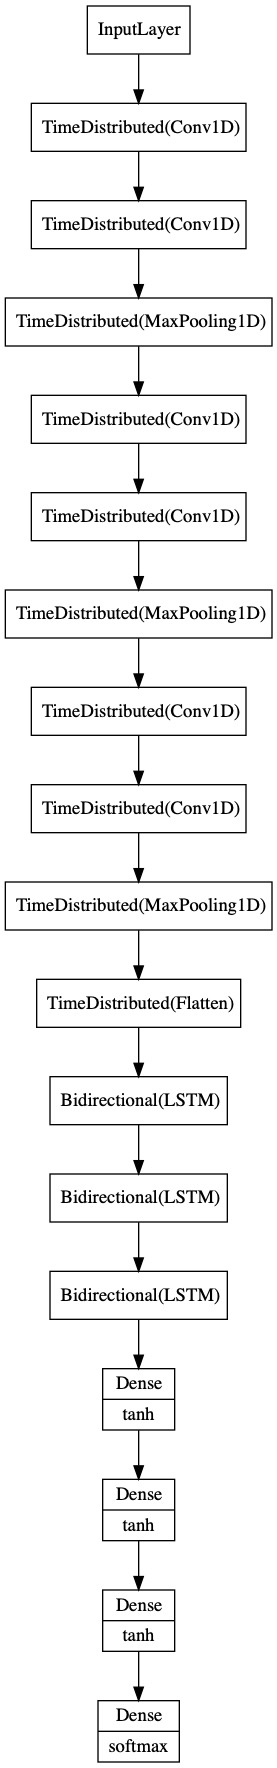

In [87]:
img_file = Path(os.path.abspath('')).parent / 'reports' / 'figures' / 'early_CNNLSTM.jpg'

early_cnnlstm = early_CNNLSTM(early_features, n_length, early_outputs)
tf.keras.utils.plot_model(early_cnnlstm, to_file=img_file, show_layer_names=False, show_layer_activations=True)

Epoch 1/50
25/25 - 38s - loss: 2.9047 - accuracy: 0.2362 - auc_57: 0.4680 - precision_57: 0.0000e+00 - recall_57: 0.0000e+00 - f1_score: 0.1809 - val_loss: 1.4439 - val_accuracy: 0.0603 - val_auc_57: 0.2932 - val_precision_57: 0.0000e+00 - val_recall_57: 0.0000e+00 - val_f1_score: 0.0284 - 38s/epoch - 2s/step
Epoch 2/50
25/25 - 26s - loss: 2.8716 - accuracy: 0.1960 - auc_57: 0.4150 - precision_57: 0.0000e+00 - recall_57: 0.0000e+00 - f1_score: 0.1398 - val_loss: 1.4018 - val_accuracy: 0.1307 - val_auc_57: 0.4366 - val_precision_57: 0.0000e+00 - val_recall_57: 0.0000e+00 - val_f1_score: 0.1056 - 26s/epoch - 1s/step
Epoch 3/50
25/25 - 26s - loss: 2.8215 - accuracy: 0.2387 - auc_57: 0.5597 - precision_57: 0.2222 - recall_57: 0.0025 - f1_score: 0.2271 - val_loss: 1.3937 - val_accuracy: 0.2513 - val_auc_57: 0.5445 - val_precision_57: 0.0000e+00 - val_recall_57: 0.0000e+00 - val_f1_score: 0.2261 - 26s/epoch - 1s/step
Epoch 4/50
25/25 - 26s - loss: 2.5062 - accuracy: 0.3492 - auc_57: 0.6662 -

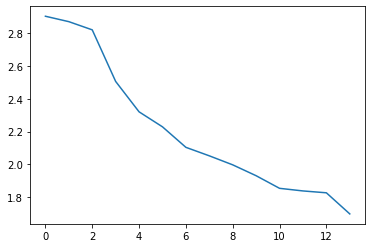

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
25/25 - 37s - loss: 2.8555 - accuracy: 0.0729 - auc_58: 0.2889 - precision_58: 0.0000e+00 - recall_58: 0.0000e+00 - f1_score: 0.0694 - val_loss: 1.3857 - val_accuracy: 0.4121 - val_auc_58: 0.5466 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_f1_score: 0.1502 - 37s/epoch - 1s/step
Epoch 2/50
25/25 - 25s - loss: 2.8229 - accuracy: 0.2575 - auc_58: 0.5275 - precision_58: 0.0000e+00 - recall_58: 0.0000e+00 - f1_score: 0.2283 - val_loss: 1.3038 - val_accuracy: 0.4322 - val_auc_58: 0.6952 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_f1_score: 0.1514 - 25s/epoch - 994ms/step
Epoch 3/50
25/25 - 26s - loss: 2.7353 - accuracy: 0.2889 - auc_58: 0.5928 - precision_58: 0.8571 - recall_58: 0.0075 - f1_score: 0.2518 - val_loss: 1.4013 - val_accuracy: 0.1859 - val_auc_58: 0.4655 - val_precision_58: 0.1111 - val_recall_58: 0.0050 - val_f1_score: 0.1693 - 26s/epoch - 1s/step
Epoch 4/50
25/25 - 24s - loss: 2.4503 - accuracy: 0.2864 - auc_58: 0.6042 - prec

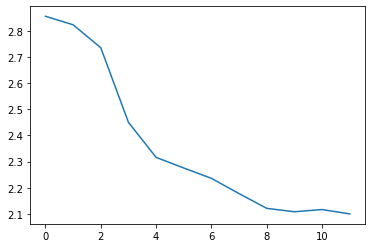

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
25/25 - 35s - loss: 2.8125 - accuracy: 0.2789 - auc_59: 0.4665 - precision_59: 0.0000e+00 - recall_59: 0.0000e+00 - f1_score: 0.1939 - val_loss: 1.3825 - val_accuracy: 0.2864 - val_auc_59: 0.5513 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.1755 - 35s/epoch - 1s/step
Epoch 2/50
25/25 - 23s - loss: 2.8002 - accuracy: 0.2864 - auc_59: 0.5643 - precision_59: 0.0000e+00 - recall_59: 0.0000e+00 - f1_score: 0.2417 - val_loss: 1.3567 - val_accuracy: 0.2965 - val_auc_59: 0.6595 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.1667 - 23s/epoch - 922ms/step
Epoch 3/50
25/25 - 24s - loss: 2.7501 - accuracy: 0.2362 - auc_59: 0.5551 - precision_59: 1.0000 - recall_59: 0.0013 - f1_score: 0.2221 - val_loss: 1.3805 - val_accuracy: 0.2412 - val_auc_59: 0.5557 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.1947 - 24s/epoch - 959ms/step
Epoch 4/50
25/25 - 22s - loss: 2.5457 - accuracy: 0.3417 - auc_59: 0.

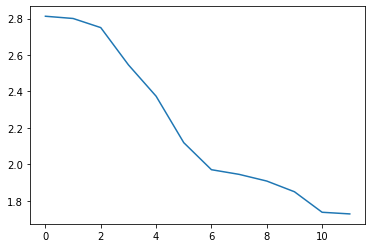

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
25/25 - 31s - loss: 2.9718 - accuracy: 0.1595 - auc_60: 0.4378 - precision_60: 0.0000e+00 - recall_60: 0.0000e+00 - f1_score: 0.1536 - val_loss: 1.3775 - val_accuracy: 0.3317 - val_auc_60: 0.5387 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1255 - 31s/epoch - 1s/step
Epoch 2/50
25/25 - 22s - loss: 2.9569 - accuracy: 0.2023 - auc_60: 0.4483 - precision_60: 0.0000e+00 - recall_60: 0.0000e+00 - f1_score: 0.1790 - val_loss: 1.3954 - val_accuracy: 0.3719 - val_auc_60: 0.5017 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1885 - 22s/epoch - 893ms/step
Epoch 3/50
25/25 - 22s - loss: 2.8477 - accuracy: 0.2601 - auc_60: 0.5251 - precision_60: 0.7273 - recall_60: 0.0101 - f1_score: 0.2524 - val_loss: 1.3483 - val_accuracy: 0.1055 - val_auc_60: 0.5661 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1055 - 22s/epoch - 893ms/step
Epoch 4/50
25/25 - 22s - loss: 2.7023 - accuracy: 0.2802 - auc_60: 0.

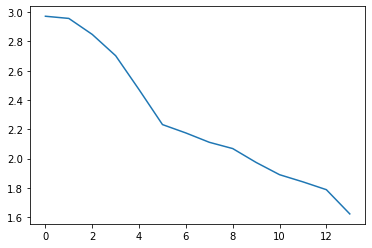

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
25/25 - 34s - loss: 2.9124 - accuracy: 0.1533 - auc_61: 0.4264 - precision_61: 0.0000e+00 - recall_61: 0.0000e+00 - f1_score: 0.1535 - val_loss: 1.4444 - val_accuracy: 0.1106 - val_auc_61: 0.3515 - val_precision_61: 0.0000e+00 - val_recall_61: 0.0000e+00 - val_f1_score: 0.0637 - 34s/epoch - 1s/step
Epoch 2/50
25/25 - 22s - loss: 2.8899 - accuracy: 0.2751 - auc_61: 0.5154 - precision_61: 0.0000e+00 - recall_61: 0.0000e+00 - f1_score: 0.2404 - val_loss: 1.4012 - val_accuracy: 0.1357 - val_auc_61: 0.4100 - val_precision_61: 0.0000e+00 - val_recall_61: 0.0000e+00 - val_f1_score: 0.1149 - 22s/epoch - 886ms/step
Epoch 3/50
25/25 - 22s - loss: 2.7839 - accuracy: 0.2538 - auc_61: 0.5407 - precision_61: 0.8889 - recall_61: 0.0101 - f1_score: 0.2603 - val_loss: 1.3033 - val_accuracy: 0.4020 - val_auc_61: 0.6843 - val_precision_61: 0.3333 - val_recall_61: 0.0050 - val_f1_score: 0.2220 - 22s/epoch - 890ms/step
Epoch 4/50
25/25 - 22s - loss: 2.5886 - accuracy: 0.3003 - auc_61: 0.5875 - p

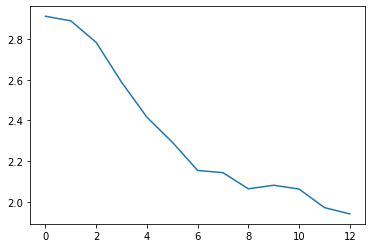

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


In [88]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    early_cnnlstm = early_CNNLSTM(early_features, n_length, early_outputs)
    history = train(early_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
    early_cnnlstm.save(model_path)

In [89]:
early_cnnlstm_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_results

{'Accuracy': 0.5575376987457276,
 'ROC/AUC': 0.8385640621185303,
 'Precision': 0.8106837511062622,
 'Recall': 0.375628137588501,
 'F1-score': 0.5203743934631347}

In [90]:
_, acc, auc, precision, recall, f1 = early_cnnlstm.evaluate(early_X_test, early_y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 12.75% - ROC/AUC: 0.42 - Precision: 0.18 - Recall: 0.03, F1 score: 0.10


### Train RCNN (with early fusion)

In [91]:
acc = []
auc = []
precision = []
recall = []
f1 = []

In [92]:
def early_RCNN(n_features, n_length, n_outputs):
   input = Input(shape=(1, n_length, n_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=100, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='he_uniform'))(input)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
   conv1d_2 = TimeDistributed(Conv1D(filters=100, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='he_uniform'))(maxpool_1)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
   conv1d_3 = TimeDistributed(Conv1D(filters=100, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='he_uniform'))(maxpool_2)
   bn_3 = TimeDistributed(BatchNormalization())(conv1d_3)
   maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_3)
   flatten = Flatten()(maxpool_3)
   dense_1 = Dense(256, activation='relu')(flatten)
   dense_2 = Dense(256, activation='relu')(dense_1)
   dense_3 = Dense(256, activation='relu')(dense_2)
   output = Dense(units=n_outputs, activation='softmax')(dense_3)
   model = Model(inputs=input, outputs=output)
   model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

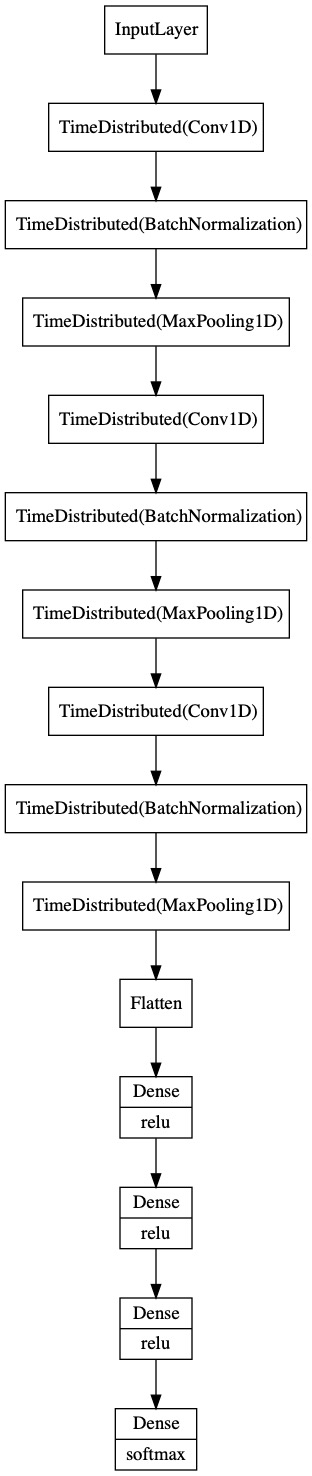

In [93]:
img_file = Path(os.path.abspath('')).parent / 'reports' / 'figures' / 'early_RCNN.jpg'

early_rcnn = early_RCNN(early_features, n_length, early_outputs)
tf.keras.utils.plot_model(early_rcnn, to_file=img_file, show_layer_names=False, show_layer_activations=True)

Epoch 1/50
4/4 - 6s - loss: 12.8209 - accuracy: 0.2789 - auc_63: 0.5924 - precision_63: 0.3117 - recall_63: 0.1746 - f1_score: 0.2243 - val_loss: 115.8474 - val_accuracy: 0.2663 - val_auc_63: 0.5109 - val_precision_63: 0.2663 - val_recall_63: 0.2663 - val_f1_score: 0.1052 - 6s/epoch - 1s/step
Epoch 2/50
4/4 - 3s - loss: 6.9658 - accuracy: 0.1394 - auc_63: 0.3711 - precision_63: 0.1463 - recall_63: 0.0992 - f1_score: 0.1405 - val_loss: 13.2199 - val_accuracy: 0.4422 - val_auc_63: 0.6436 - val_precision_63: 0.4422 - val_recall_63: 0.4422 - val_f1_score: 0.1686 - 3s/epoch - 862ms/step
Epoch 3/50
4/4 - 4s - loss: 4.1170 - accuracy: 0.3417 - auc_63: 0.6253 - precision_63: 0.3918 - recall_63: 0.1432 - f1_score: 0.2698 - val_loss: 9.5367 - val_accuracy: 0.2663 - val_auc_63: 0.5148 - val_precision_63: 0.2663 - val_recall_63: 0.2663 - val_f1_score: 0.1111 - 4s/epoch - 876ms/step
Epoch 4/50
4/4 - 3s - loss: 3.1294 - accuracy: 0.3191 - auc_63: 0.6144 - precision_63: 0.3745 - recall_63: 0.1294 - f

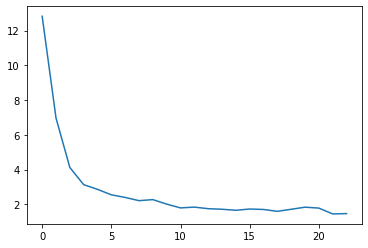

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
4/4 - 5s - loss: 11.4563 - accuracy: 0.2814 - auc_64: 0.5332 - precision_64: 0.3065 - recall_64: 0.2060 - f1_score: 0.2311 - val_loss: 63.9497 - val_accuracy: 0.0804 - val_auc_64: 0.3869 - val_precision_64: 0.0804 - val_recall_64: 0.0804 - val_f1_score: 0.0372 - 5s/epoch - 1s/step
Epoch 2/50
4/4 - 3s - loss: 4.2443 - accuracy: 0.2877 - auc_64: 0.5476 - precision_64: 0.2620 - recall_64: 0.1168 - f1_score: 0.2419 - val_loss: 21.0524 - val_accuracy: 0.4372 - val_auc_64: 0.6248 - val_precision_64: 0.4372 - val_recall_64: 0.4372 - val_f1_score: 0.1521 - 3s/epoch - 867ms/step
Epoch 3/50
4/4 - 3s - loss: 4.1851 - accuracy: 0.1709 - auc_64: 0.5029 - precision_64: 0.1711 - recall_64: 0.1143 - f1_score: 0.1563 - val_loss: 23.9454 - val_accuracy: 0.1508 - val_auc_64: 0.4299 - val_precision_64: 0.1508 - val_recall_64: 0.1508 - val_f1_score: 0.0814 - 3s/epoch - 836ms/step
Epoch 4/50
4/4 - 3s - loss: 3.1949 - accuracy: 0.4083 - auc_64: 0.6657 - precision_64: 0.4328 - recall_64: 0.2387 - f

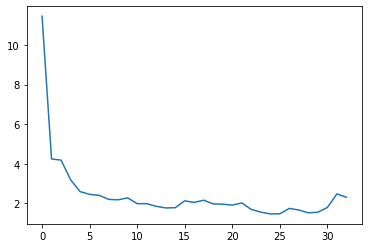

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
4/4 - 5s - loss: 6.4498 - accuracy: 0.2952 - auc_65: 0.4973 - precision_65: 0.3028 - recall_65: 0.1784 - f1_score: 0.2338 - val_loss: 231.4457 - val_accuracy: 0.3216 - val_auc_65: 0.5460 - val_precision_65: 0.3216 - val_recall_65: 0.3216 - val_f1_score: 0.1429 - 5s/epoch - 1s/step
Epoch 2/50
4/4 - 3s - loss: 12.1213 - accuracy: 0.2663 - auc_65: 0.5068 - precision_65: 0.2731 - recall_65: 0.1784 - f1_score: 0.2473 - val_loss: 20.7208 - val_accuracy: 0.4523 - val_auc_65: 0.6355 - val_precision_65: 0.4523 - val_recall_65: 0.4523 - val_f1_score: 0.1695 - 3s/epoch - 804ms/step
Epoch 3/50
4/4 - 3s - loss: 5.4526 - accuracy: 0.3015 - auc_65: 0.6087 - precision_65: 0.3276 - recall_65: 0.2412 - f1_score: 0.2418 - val_loss: 13.5893 - val_accuracy: 0.4573 - val_auc_65: 0.6387 - val_precision_65: 0.4545 - val_recall_65: 0.4523 - val_f1_score: 0.2037 - 3s/epoch - 807ms/step
Epoch 4/50
4/4 - 3s - loss: 4.0819 - accuracy: 0.4171 - auc_65: 0.6754 - precision_65: 0.4527 - recall_65: 0.2827 - 

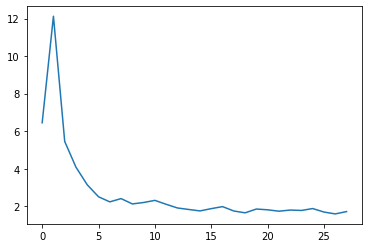

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
4/4 - 6s - loss: 8.5382 - accuracy: 0.2663 - auc_66: 0.5210 - precision_66: 0.3002 - recall_66: 0.1784 - f1_score: 0.2134 - val_loss: 184.7407 - val_accuracy: 0.3367 - val_auc_66: 0.5578 - val_precision_66: 0.3367 - val_recall_66: 0.3367 - val_f1_score: 0.1259 - 6s/epoch - 1s/step
Epoch 2/50
4/4 - 3s - loss: 7.0620 - accuracy: 0.3090 - auc_66: 0.5387 - precision_66: 0.3273 - recall_66: 0.2048 - f1_score: 0.2662 - val_loss: 30.9772 - val_accuracy: 0.0905 - val_auc_66: 0.4346 - val_precision_66: 0.0905 - val_recall_66: 0.0905 - val_f1_score: 0.0433 - 3s/epoch - 873ms/step
Epoch 3/50
4/4 - 4s - loss: 4.1937 - accuracy: 0.3631 - auc_66: 0.5901 - precision_66: 0.4079 - recall_66: 0.1809 - f1_score: 0.2954 - val_loss: 8.2706 - val_accuracy: 0.0955 - val_auc_66: 0.4737 - val_precision_66: 0.0960 - val_recall_66: 0.0955 - val_f1_score: 0.0475 - 4s/epoch - 896ms/step
Epoch 4/50
4/4 - 4s - loss: 3.1086 - accuracy: 0.2525 - auc_66: 0.5249 - precision_66: 0.3049 - recall_66: 0.1482 - f1

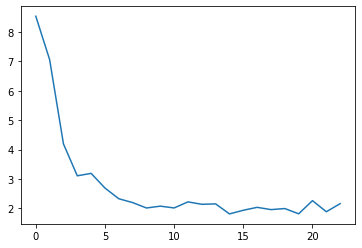

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
4/4 - 5s - loss: 10.1197 - accuracy: 0.2789 - auc_67: 0.5384 - precision_67: 0.2958 - recall_67: 0.1784 - f1_score: 0.2477 - val_loss: 98.3415 - val_accuracy: 0.1156 - val_auc_67: 0.4031 - val_precision_67: 0.1156 - val_recall_67: 0.1156 - val_f1_score: 0.1082 - 5s/epoch - 1s/step
Epoch 2/50
4/4 - 3s - loss: 5.1234 - accuracy: 0.2462 - auc_67: 0.4751 - precision_67: 0.2363 - recall_67: 0.1520 - f1_score: 0.2147 - val_loss: 30.9062 - val_accuracy: 0.4673 - val_auc_67: 0.6449 - val_precision_67: 0.4673 - val_recall_67: 0.4673 - val_f1_score: 0.1592 - 3s/epoch - 860ms/step
Epoch 3/50
4/4 - 3s - loss: 4.6889 - accuracy: 0.2802 - auc_67: 0.5491 - precision_67: 0.3169 - recall_67: 0.2098 - f1_score: 0.2198 - val_loss: 26.7242 - val_accuracy: 0.2915 - val_auc_67: 0.5303 - val_precision_67: 0.2915 - val_recall_67: 0.2915 - val_f1_score: 0.1302 - 3s/epoch - 855ms/step
Epoch 4/50
4/4 - 3s - loss: 3.6363 - accuracy: 0.2651 - auc_67: 0.4945 - precision_67: 0.3047 - recall_67: 0.1696 - f

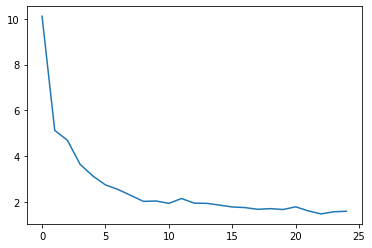

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


In [94]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    early_rcnn = early_RCNN(early_features, n_length, early_outputs)
    history = train(early_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=256, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
    early_rcnn.save(model_path)

In [95]:
early_rcnn_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_results

{'Accuracy': 0.5967336773872376,
 'ROC/AUC': 0.8394369840621948,
 'Precision': 0.6496870756149292,
 'Recall': 0.49346734285354615,
 'F1-score': 0.5819157838821412}

In [96]:
_, acc, auc, precision, recall, f1 = early_rcnn.evaluate(early_X_test, early_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 49.02% - ROC/AUC: 0.75 - Precision: 0.49 - Recall: 0.49, F1 score: 0.17


## 3. Late Fusion - Fusion is performed at decision level

In late fusion, I test two approaches, in both uni-modal classifiers are trained individually, and then either: 

- Their final dense (decision) layer is concatenated to produce the final prediction; or 

- Ensemble the uni-modal classifiers.

Just as with early fusion, we have the issue that the face modality is missing about half of the times and therefore, I can only use late fusion if both modalities are present.

### Apply Data Augmentation

In [97]:
body_X_train, body_X_test, y_train, y_test = load_latefusion_dataset('processed', 'skeleton')
body_X = body_X_train.copy()
y = y_train.copy()

print(body_X_train.shape, y_train.shape)
print(body_X_test.shape, y_test.shape)

n_length, body_features, body_outputs = body_X_train.shape[2], body_X_train.shape[-1], y_train.shape[1]

(495, 1, 350, 38) (495, 4)
(102, 1, 350, 38) (102, 4)


In [98]:
jitter_X = jitter(body_X, sigma=0.03)

In [99]:
reshaped_X = body_X.reshape((body_X.shape[0], body_X.shape[2], body_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [100]:
augmented_X = np.concatenate((rotated_X[0:250], jitter_X[0:250]), axis=0)
add_y = np.concatenate((y[0:250], y[0:250]), axis=0)
body_X = np.concatenate((augmented_X, body_X), axis=0)
y = np.concatenate((add_y, y), axis=0) 
body_X.shape

(995, 1, 350, 38)

In [101]:
jitter_X = jitter(face_X, sigma=0.03)

In [102]:
reshaped_X = face_X.reshape((face_X.shape[0], face_X.shape[2], face_X.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))

In [103]:
augmented_X = np.concatenate((rotated_X[0:250], jitter_X[0:250]), axis=0)
face_X = np.concatenate((augmented_X, face_X), axis=0)
face_X.shape

(995, 1, 350, 10)

In [104]:
umild, lmoderate, lmild, umoderate = np.sum(y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for Upper Body Pain Mild Level: {:.2f}'.format(weight_for_0))
print('Weight for Upper Body Pain Moderate Level: {:.2f}'.format(weight_for_3))
print('Weight for Lower Body Pain Mild Level: {:.2f}'.format(weight_for_2))
print('Weight for Lower Body Pain Moderate Level: {:.2f}'.format(weight_for_1))

Weight for Upper Body Pain Mild Level: 1.04
Weight for Upper Body Pain Moderate Level: 6.91
Weight for Lower Body Pain Mild Level: 1.54
Weight for Lower Body Pain Moderate Level: 4.04


### CNN + Bidirectional LSTM (concatenate decision layer)

In [105]:
acc = []
auc = []
precision = []
recall = []
f1 = []

In [106]:
def build_fusioned_CNN(body_features, face_features, n_length, n_outputs):
    input_1 = Input(shape=(1, n_length, body_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(input_1)
    conv1d_11 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_11)
    conv1d_111 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(maxpool_1)
    conv1d_1111 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(conv1d_111)
    maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1111)
    conv1d_1111 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(maxpool_11)
    conv1d_11111 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh', kernel_initializer='he_uniform'))(conv1d_1111)
    maxpool_111 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_11111)
    flatten_1 = TimeDistributed(Flatten())(maxpool_111)
    lstm_1 = Bidirectional(LSTM(100, return_sequences=True))(flatten_1)
    lstm_11 = Bidirectional(LSTM(100, return_sequences=True))(lstm_1)
    lstm_111 = Bidirectional(LSTM(100))(lstm_11)
    dense_1 = Dense(100, activation='tanh')(lstm_111)
    dense_11 = Dense(100, activation='tanh')(dense_1)
    dense_111 = Dense(100, activation='tanh')(dense_11)

    input_2 = Input(shape=(1, n_length, face_features))
    conv1d_2 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation='relu', kernel_initializer='glorot_normal'))(input_2)
    conv1d_22 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation='relu', kernel_initializer='glorot_normal'))(conv1d_2)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_22)
    conv1d_222 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation='relu', kernel_initializer='glorot_normal'))(maxpool_2)
    conv1d_2222 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation='relu', kernel_initializer='glorot_normal'))(conv1d_222)
    maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2222)
    conv1d_2222 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation='relu', kernel_initializer='glorot_normal'))(maxpool_22)
    conv1d_22222 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation='relu', kernel_initializer='glorot_normal'))(conv1d_2222)
    maxpool_222 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_22222)
    flatten_2 = TimeDistributed(Flatten())(maxpool_222)
    lstm_2 = Bidirectional(LSTM(250, return_sequences=True))(flatten_2)
    lstm_22 = Bidirectional(LSTM(250, return_sequences=True))(lstm_2)
    lstm_222 = Bidirectional(LSTM(250))(lstm_22)
    dense_2 = Dense(250, activation='relu')(lstm_222)
    dense_22 = Dense(250, activation='relu')(dense_2)
    dense_222 = Dense(250, activation='relu')(dense_22)

    concat = Concatenate()([dense_111, dense_222])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

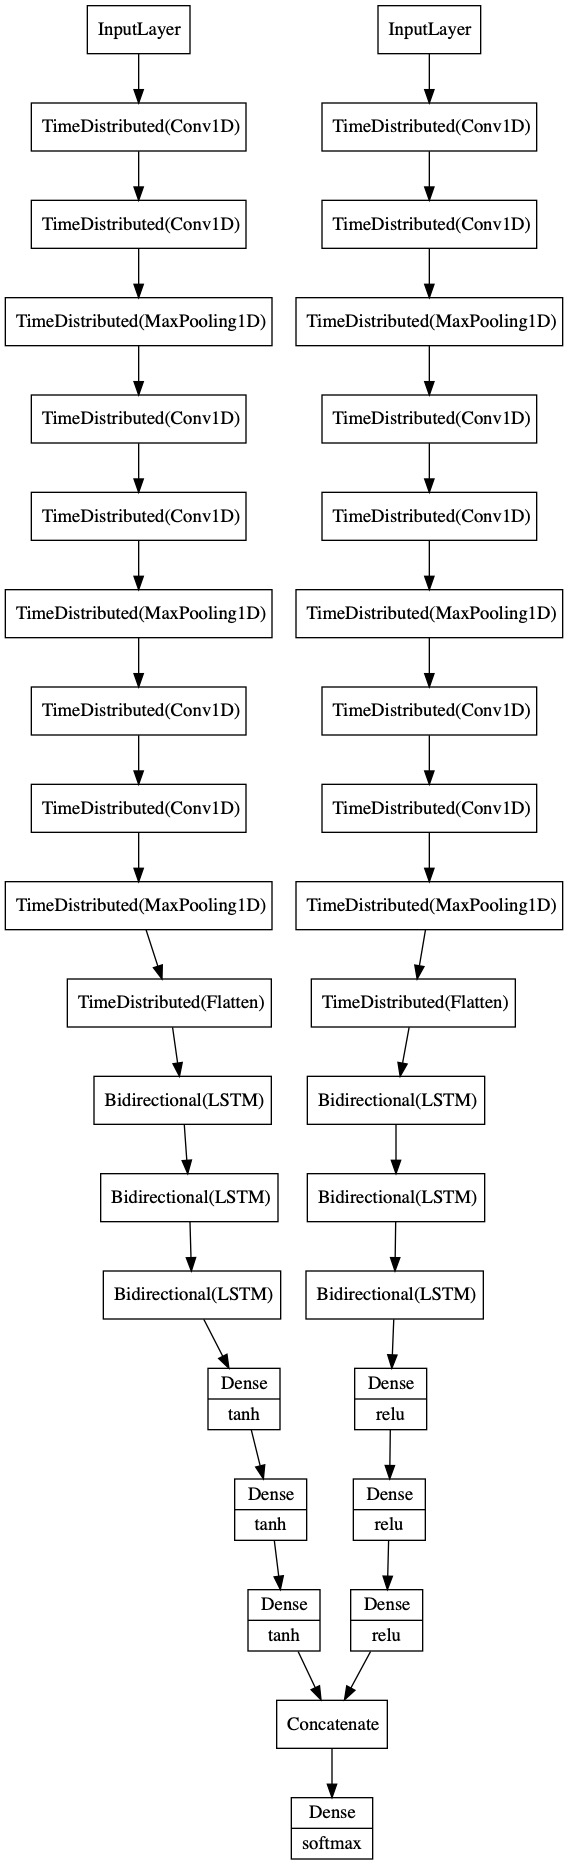

In [107]:
img_file = Path(os.path.abspath('')).parent / 'reports' / 'figures' / 'late_CNNLSTM.jpg'

late_cnnlstm = build_fusioned_CNN(body_features, face_features, n_length, body_outputs)
tf.keras.utils.plot_model(late_cnnlstm, to_file=img_file, show_layer_names=False, show_layer_activations=True)

Epoch 1/50
7/7 - 40s - loss: 2.7784 - accuracy: 0.3681 - auc_69: 0.6439 - precision_69: 0.0000e+00 - recall_69: 0.0000e+00 - f1_score: 0.2444 - val_loss: 1.3762 - val_accuracy: 0.2864 - val_auc_69: 0.6475 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.1346 - 40s/epoch - 6s/step
Epoch 2/50
7/7 - 19s - loss: 2.7547 - accuracy: 0.3606 - auc_69: 0.6734 - precision_69: 0.0000e+00 - recall_69: 0.0000e+00 - f1_score: 0.2199 - val_loss: 1.3518 - val_accuracy: 0.3518 - val_auc_69: 0.6389 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.3102 - 19s/epoch - 3s/step
Epoch 3/50
7/7 - 17s - loss: 2.7223 - accuracy: 0.3543 - auc_69: 0.6685 - precision_69: 0.0000e+00 - recall_69: 0.0000e+00 - f1_score: 0.3053 - val_loss: 1.3314 - val_accuracy: 0.3367 - val_auc_69: 0.6312 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.3052 - 17s/epoch - 2s/step
Epoch 4/50
7/7 - 18s - loss: 2.6641 - accuracy: 0.3731 - auc_69: 0.6865 -

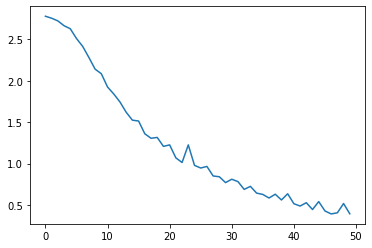

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
7/7 - 39s - loss: 2.7426 - accuracy: 0.2437 - auc_70: 0.4953 - precision_70: 0.0000e+00 - recall_70: 0.0000e+00 - f1_score: 0.1998 - val_loss: 1.3627 - val_accuracy: 0.4322 - val_auc_70: 0.6556 - val_precision_70: 0.0000e+00 - val_recall_70: 0.0000e+00 - val_f1_score: 0.1519 - 39s/epoch - 6s/step
Epoch 2/50
7/7 - 16s - loss: 2.7330 - accuracy: 0.3442 - auc_70: 0.6370 - precision_70: 0.0000e+00 - recall_70: 0.0000e+00 - f1_score: 0.2297 - val_loss: 1.3579 - val_accuracy: 0.4372 - val_auc_70: 0.6935 - val_precision_70: 0.0000e+00 - val_recall_70: 0.0000e+00 - val_f1_score: 0.2111 - 16s/epoch - 2s/step
Epoch 3/50
7/7 - 15s - loss: 2.7220 - accuracy: 0.4435 - auc_70: 0.6964 - precision_70: 0.0000e+00 - recall_70: 0.0000e+00 - f1_score: 0.3017 - val_loss: 1.3655 - val_accuracy: 0.4121 - val_auc_70: 0.6187 - val_precision_70: 0.0000e+00 - val_recall_70: 0.0000e+00 - val_f1_score: 0.2335 - 15s/epoch - 2s/step
Epoch 4/50
7/7 - 15s - loss: 2.6842 - accuracy: 0.4158 - auc_70: 0.6607 -

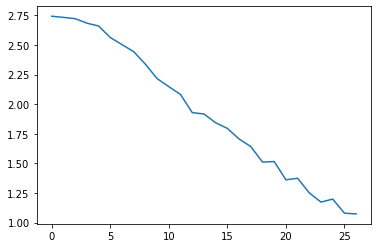

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
7/7 - 36s - loss: 2.7075 - accuracy: 0.2852 - auc_71: 0.5660 - precision_71: 0.0000e+00 - recall_71: 0.0000e+00 - f1_score: 0.1994 - val_loss: 1.3706 - val_accuracy: 0.4523 - val_auc_71: 0.6946 - val_precision_71: 0.0000e+00 - val_recall_71: 0.0000e+00 - val_f1_score: 0.1557 - 36s/epoch - 5s/step
Epoch 2/50
7/7 - 15s - loss: 2.6955 - accuracy: 0.3492 - auc_71: 0.6977 - precision_71: 0.0000e+00 - recall_71: 0.0000e+00 - f1_score: 0.2408 - val_loss: 1.3673 - val_accuracy: 0.3266 - val_auc_71: 0.6306 - val_precision_71: 0.0000e+00 - val_recall_71: 0.0000e+00 - val_f1_score: 0.1824 - 15s/epoch - 2s/step
Epoch 3/50
7/7 - 15s - loss: 2.6676 - accuracy: 0.3631 - auc_71: 0.6967 - precision_71: 0.0000e+00 - recall_71: 0.0000e+00 - f1_score: 0.2574 - val_loss: 1.3221 - val_accuracy: 0.4322 - val_auc_71: 0.6954 - val_precision_71: 0.0000e+00 - val_recall_71: 0.0000e+00 - val_f1_score: 0.1596 - 15s/epoch - 2s/step
Epoch 4/50
7/7 - 15s - loss: 2.6464 - accuracy: 0.4598 - auc_71: 0.7319 -

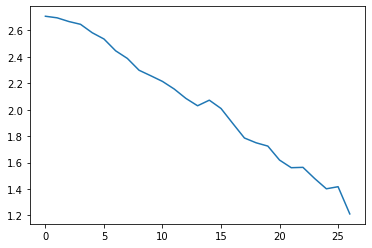

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
7/7 - 36s - loss: 2.8572 - accuracy: 0.1181 - auc_72: 0.3492 - precision_72: 0.0000e+00 - recall_72: 0.0000e+00 - f1_score: 0.0943 - val_loss: 1.3758 - val_accuracy: 0.4824 - val_auc_72: 0.7048 - val_precision_72: 0.0000e+00 - val_recall_72: 0.0000e+00 - val_f1_score: 0.2342 - 36s/epoch - 5s/step
Epoch 2/50
7/7 - 15s - loss: 2.8471 - accuracy: 0.3191 - auc_72: 0.5697 - precision_72: 0.0000e+00 - recall_72: 0.0000e+00 - f1_score: 0.2672 - val_loss: 1.4048 - val_accuracy: 0.1256 - val_auc_72: 0.3568 - val_precision_72: 0.0000e+00 - val_recall_72: 0.0000e+00 - val_f1_score: 0.0979 - 15s/epoch - 2s/step
Epoch 3/50
7/7 - 15s - loss: 2.8277 - accuracy: 0.2337 - auc_72: 0.4745 - precision_72: 0.0000e+00 - recall_72: 0.0000e+00 - f1_score: 0.2207 - val_loss: 1.3796 - val_accuracy: 0.1608 - val_auc_72: 0.5178 - val_precision_72: 0.0000e+00 - val_recall_72: 0.0000e+00 - val_f1_score: 0.1334 - 15s/epoch - 2s/step
Epoch 4/50
7/7 - 15s - loss: 2.7797 - accuracy: 0.2676 - auc_72: 0.5670 -

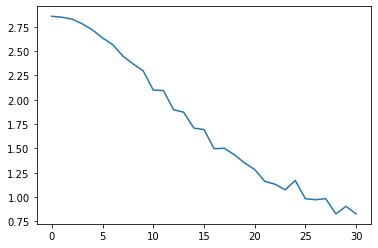

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


Epoch 1/50
7/7 - 33s - loss: 2.7946 - accuracy: 0.2688 - auc_73: 0.4634 - precision_73: 0.0000e+00 - recall_73: 0.0000e+00 - f1_score: 0.1567 - val_loss: 1.4005 - val_accuracy: 0.1106 - val_auc_73: 0.3018 - val_precision_73: 0.0000e+00 - val_recall_73: 0.0000e+00 - val_f1_score: 0.0843 - 33s/epoch - 5s/step
Epoch 2/50
7/7 - 15s - loss: 2.7833 - accuracy: 0.1382 - auc_73: 0.4242 - precision_73: 0.0000e+00 - recall_73: 0.0000e+00 - f1_score: 0.0981 - val_loss: 1.4092 - val_accuracy: 0.0955 - val_auc_73: 0.3286 - val_precision_73: 0.0000e+00 - val_recall_73: 0.0000e+00 - val_f1_score: 0.0911 - 15s/epoch - 2s/step
Epoch 3/50
7/7 - 15s - loss: 2.7680 - accuracy: 0.2023 - auc_73: 0.4743 - precision_73: 0.0000e+00 - recall_73: 0.0000e+00 - f1_score: 0.1801 - val_loss: 1.3753 - val_accuracy: 0.2161 - val_auc_73: 0.5588 - val_precision_73: 0.0000e+00 - val_recall_73: 0.0000e+00 - val_f1_score: 0.1742 - 15s/epoch - 2s/step
Epoch 4/50
7/7 - 15s - loss: 2.7083 - accuracy: 0.2638 - auc_73: 0.6063 -

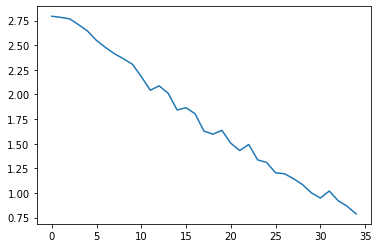

INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


INFO:tensorflow:Assets written to: /Users/mnktech/Documents/GitHub/masters-thesis/models/saved/assets


In [108]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    late_cnnlstm = build_fusioned_CNN(body_features, face_features, n_length, body_outputs)
    history = train_fusioned(late_cnnlstm, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=128, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
    late_cnnlstm.save(model_path)

In [ ]:
late_cnnlstm_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_results

In [ ]:
_, acc, auc, precision, recall, f1 = late_cnnlstm.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('CNN + Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

### RCNN (concatenate decision layer)

In [ ]:
acc = []
auc = []
precision = []
recall = []
f1 = []

In [69]:
def build_fusioned_RCNN(body_features, face_features, n_length, n_outputs):
   input_1 = Input(shape=(1, n_length, body_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(input_1)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
   conv1d_11 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(maxpool_1)
   bn_11 = TimeDistributed(BatchNormalization())(conv1d_11)
   maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_11)
   conv1d_111 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(maxpool_11)
   bn_111 = TimeDistributed(BatchNormalization())(conv1d_111)
   maxpool_111 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_111)
   flatten_1 = Flatten()(maxpool_111)
   dense_1 = Dense(256, activation='relu')(flatten_1)
   dense_11 = Dense(256, activation='relu')(dense_1)
   dense_111 = Dense(256, activation='relu')(dense_11)

   input_2 = Input(shape=(1, n_length, face_features))
   conv1d_2 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(input_2)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
   conv1d_22 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(maxpool_2)
   bn_22 = TimeDistributed(BatchNormalization())(conv1d_22)
   maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_22)
   conv1d_222 = TimeDistributed(Conv1D(filters=250, kernel_size=5, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_normal'))(maxpool_22)
   bn_222 = TimeDistributed(BatchNormalization())(conv1d_222)
   maxpool_222 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_222)
   flatten_2 = Flatten()(maxpool_222)
   dense_2 = Dense(256, activation='tanh')(flatten_2)
   dense_22 = Dense(256, activation='tanh')(dense_2)
   dense_222 = Dense(256, activation='tanh')(dense_22)

   concat = Concatenate()([dense_111, dense_222])
   output = Dense(units=n_outputs, activation='softmax')(concat)
   model = Model(inputs=[input_1, input_2], outputs=[output])
   model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

In [ ]:
img_file = Path(os.path.abspath('')).parent / 'reports' / 'figures' / 'late_RCNN.jpg'

late_rcnn = build_fusioned_CNN(body_features, face_features, n_length, body_outputs)
tf.keras.utils.plot_model(late_rcnn, to_file=img_file, show_layer_names=False, show_layer_activations=True)

In [70]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    late_rcnn = build_fusioned_RCNN(body_features, face_features, n_length, body_outputs)
    history = train_fusioned(late_rcnn, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=128, class_weight=class_weight)    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
    late_rcnn.save(model_path)

Epoch 1/50
4/4 - 10s - loss: 81.9631 - accuracy: 0.2803 - auc_15: 0.5345 - precision_15: 0.3000 - recall_15: 0.2348 - f1_score: 0.2335 - val_loss: 197.8969 - val_accuracy: 0.5253 - val_auc_15: 0.6835 - val_precision_15: 0.5253 - val_recall_15: 0.5253 - val_f1_score: 0.1722 - 10s/epoch - 3s/step
Epoch 2/50
4/4 - 5s - loss: 31.5954 - accuracy: 0.2803 - auc_15: 0.5308 - precision_15: 0.2803 - recall_15: 0.2803 - f1_score: 0.2415 - val_loss: 122.8204 - val_accuracy: 0.1515 - val_auc_15: 0.4370 - val_precision_15: 0.1515 - val_recall_15: 0.1515 - val_f1_score: 0.1094 - 5s/epoch - 1s/step
Epoch 3/50
4/4 - 5s - loss: 18.2768 - accuracy: 0.2626 - auc_15: 0.5228 - precision_15: 0.2621 - recall_15: 0.2601 - f1_score: 0.2285 - val_loss: 318.3914 - val_accuracy: 0.0707 - val_auc_15: 0.3805 - val_precision_15: 0.0707 - val_recall_15: 0.0707 - val_f1_score: 0.0333 - 5s/epoch - 1s/step
Epoch 4/50
4/4 - 5s - loss: 13.0919 - accuracy: 0.3005 - auc_15: 0.5499 - precision_15: 0.2961 - recall_15: 0.2879 -

In [ ]:
late_rcnn_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_results

In [ ]:
_, acc, auc, precision, recall, f1 = late_rcnn.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

### Convert Uni-modal Approaches to Ensemble Members

In [72]:
cnnlstm_body_member = KerasMember(name="Body Model", keras_model=body_cnnlstm, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
cnnlstm_face_member = KerasMember(name="Face Model", keras_model=face_cnnlstm, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

In [74]:
rcnn_body_member = KerasMember(name="Body Model", keras_model=body_rcnn, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
rcnn_face_member = KerasMember(name="Face Model", keras_model=face_rcnn, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

### Dirichlet Markov Ensemble with weighted soft voting

In [76]:
cnnlstm_dirichletEnsemble = DirichletEnsemble()
cnnlstm_dirichletEnsemble.add_member(cnnlstm_body_member)
cnnlstm_dirichletEnsemble.add_member(cnnlstm_face_member)
cnnlstm_dirichletEnsemble.fit()

In [78]:
rcnn_dirichletEnsemble = DirichletEnsemble()
rcnn_dirichletEnsemble.add_member(rcnn_body_member)
rcnn_dirichletEnsemble.add_member(rcnn_face_member)
rcnn_dirichletEnsemble.fit()

## Performance Evaluation on Test set

### Late Fusion (Decision Level)

In [95]:
print('BiLSTM Dirichlet Markov Ensemble:')
d = biLSTM_dirichletEnsemble.describe()

BiLSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.0008)
Face Model (weight: 0.9992)
Accuracy: 32.35% - ROC/AUC: 0.60 - Precision: 0.33 - Recall: 0.29 - F1 score: 0.23


In [96]:
print('CNN+LSTM Dirichlet Markov Ensemble:')
d = cnn_dirichletEnsemble.describe()

CNN+LSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.9944)
Face Model (weight: 0.0056)
Accuracy: 46.08% - ROC/AUC: 0.61 - Precision: 0.28 - Recall: 0.25 - F1 score: 0.23


In [97]:
print('ConvLSTM Dirichlet Markov Ensemble:')
d = convLSTM_dirichletEnsemble.describe()

ConvLSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.2806)
Face Model (weight: 0.7194)
Accuracy: 49.02% - ROC/AUC: 0.63 - Precision: 0.26 - Recall: 0.26 - F1 score: 0.26


In [98]:
print('RCNN Dirichlet Markov Ensemble:')
d = rcnn_dirichletEnsemble.describe()

RCNN Dirichlet Markov Ensemble:
Body Model (weight: 0.0000)
Face Model (weight: 1.0000)
Accuracy: 36.27% - ROC/AUC: 0.57 - Precision: 0.26 - Recall: 0.25 - F1 score: 0.23
